### Imports y rcParams

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, area_opening, skeletonize, area_closing, binary_erosion, binary_dilation
import pandas as pd
from matplotlib import rcParams
from skimage.measure import find_contours

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (18, 10)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

THRESHOLD = 120
MAX_PIXEL_VALUE = 255


### Funciones

In [67]:
def cortar(frame, limites):
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x]
    return corte

def gris(frame):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    return im_gray

def binarize(frame, th=THRESHOLD):
    _, im_binary = cv.threshold(frame, th, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    return im_binary

def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def guillotina(frame):
    # encuentra la cabeza
    y, x = np.where(frame<=130)
    # pinta esos puntos del valor promedio de la imagen 
    frame[y, x] = np.mean(frame)
    # renormaliza la matriz por los máximos y mínimos valores de la imagen sin la cabeza
    frame -= np.min(frame)
    frame = (frame/np.max(frame))*255
    return frame

def binarize_TAIL(frame):
    _, im_binary = cv.threshold(frame, THRESHOLD-15, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    # rellena manchas negras del fondo
    arr = im_binary > 0
    im_binary = remove_small_holes(arr)*255
    # rellena manchas blancas dentro del cuerpo del filamento
    y, x = np.where(im_binary==0)
    im_bin = im_binary[min(y)-1:max(y)+2, min(x)-1:max(x)+2]
    im_bin = area_opening(im_bin, 400)
    im_binary[min(y)-1:max(y)+2, min(x)-1:max(x)+2] = im_bin
    return im_binary

def skeleton(frame):
    arr = frame < 255
    sk = skeletonize(arr)*255
    # si sobre una columna que ocupa el esqueleto de la cola hay más de un píxel blanco (debido a globos o ramas)
    # rellena esos puntos con negro y ubica un píxel blanco en la fila "promedio" de esos puntos.
    _, x = np.where(sk!=0)
    for c in np.unique(x):
        r = np.where(sk[:, c]!=0)[0]
        for p in r:
            sk[p, c] = 0
        sk[int(np.mean(r)), c] = 255
    tail = np.where(sk!=0)
    # devuelve la matriz y las coordenadas del esqueleto en la misma
    return sk, tail

def track_TAIL(vs, limites, SHOW=False):
        pos_sk = [] # matrices de skeletonize
        pos_tail = [] # coordenadas del cuerpo
        i=0
        count=0
        lista_count=[] # frames analizados 
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                count +=1
                frame = cortar(frame, limites)

                # para que sólo analice los frames donde se puede ver la cola completa dentro del cuadro:
                im_izq = frame[:, 0:1]
                im_izq = cv.bitwise_not(binarize(gris(im_izq), th=100))
                im_der = frame[:, -2:-1]
                im_der = cv.bitwise_not(binarize(gris(im_der), th=160))
                if np.sum(im_izq) == 0:
                    if np.sum(im_der) == 0:
                        lista_count.append(count)
                        frame_bn = binarize_TAIL(guillotina(gris(frame)))
                        x_tail, y_tail = np.where(frame_bn==0)
                        sk, tail = skeleton(frame_bn)
                        pos_sk.append(sk)
                        pos_tail.append(tail)
                        if SHOW:
                            # frame[x_tail,y_tail] = [0, 255, 0] # esto señala todo el filamento, no solo el esqueleto                            
                            frame[tail[0],tail[1]] = [0, 0, 255]
                            cv.imshow('frame', frame)
                        i+=1
                        if cv.waitKey(1) & 0xFF == ord('q'): # quit con q
                            break
                else:
                    # print('termina en:',count)
                    break
            else:
                print('Video no leído')
                break
        cv.destroyAllWindows()
        tiempo = [f for f in range(1, len(pos_sk)+1)]

        return i, lista_count, np.array(tiempo, dtype='object'), np.array(pos_sk, dtype='object'), np.array(pos_tail, dtype='object')

### Otras funciones (revisar después de mirar _tracking.ipynb_ con Nico) 

In [4]:
def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize(gris(frame))
                mask = frame_bn>0
                frame_bn = remove_small_holes(mask,10)*255
                try:
                    x, y, x_head, y_head = find(frame_bn)
                    pos_x.append(x_head)
                    pos_y.append(y_head)
                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                        cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def combineta(vs, limites, SHOW=False, SAVE=False):  # para generar el gif
        # coordenadas de la cola en cada frame
        tail_x = np.array([])
        tail_y = np.array([])        

        pos_x = []
        pos_y = []

        frame_count = vs.get(7)
        fps = 60
        tiempo = [f for f in range(1, int(frame_count))]

        # output = cv.VideoWriter('videos/video.mp4', cv.VideoWriter_fourcc(*"mp4v"), fps, frame_size)

        count = 0
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = cortar(frame, limites)

                # para que sólo tome cuando la cola está completa:
                im_der = frame[:, -2:-1]
                im_der = cv.bitwise_not(binarize(gris(im_der), th=170))

                # frame_width = int(frame.get(3))
                # frame_height = int(frame.get(4))
                # frame_size = (frame_width,frame_height)

                if np.sum(im_der) == 0:
                    count+=1
                    frame_bn_tail = binarize_TAIL(guillotina(gris(frame)))
                    _, x_tail, y_tail = skeleton(frame_bn_tail)
                    tail_x = np.append(tail_x, x_tail)
                    tail_y = np.append(tail_y, y_tail)

                    frame_bn = binarize(gris(frame))
                    mask = frame_bn>0
                    frame_bn = remove_small_holes(mask,10)*255

                    frame_width = limites[1]-limites[0]
                    frame_height = limites[2] - limites[3]
                    frame_size = (frame_width, frame_height)

                    try:
                        x, y, x_head, y_head = find(frame_bn)
                        pos_x.append(x_head)
                        pos_y.append(y_head)
                        if SHOW:
                            frame[y, x] = [0, 255, 0]
                            frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 0), thickness=-1)
                            frame[y_tail, x_tail] = [0, 0, 255]
                            # cv.imwrite(f'fotos\\analisis\\frame_{count}.jpg', frame)
                            cv.imshow('frame', frame)
                        # if SAVE:
                            # output.write(frame)
                            
                    except:
                        break
                    if cv.waitKey(1) & 0xFF == ord('q'):
                        break
                
            else:
                print('Video no abierto')
                break
        # output.release()
        cv.destroyAllWindows()

        return count, frame_size, tail_x, tail_y

In [6]:
# lim = [319, 950, 250, 505]
lim = [310, 950, 205, 505]

### Ejemplo del tratamiento para un frame

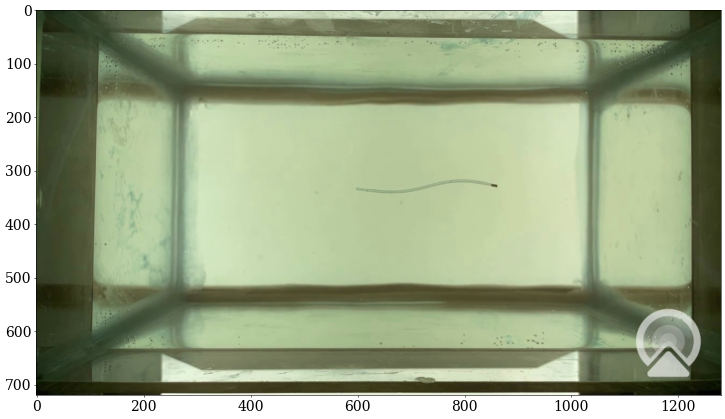

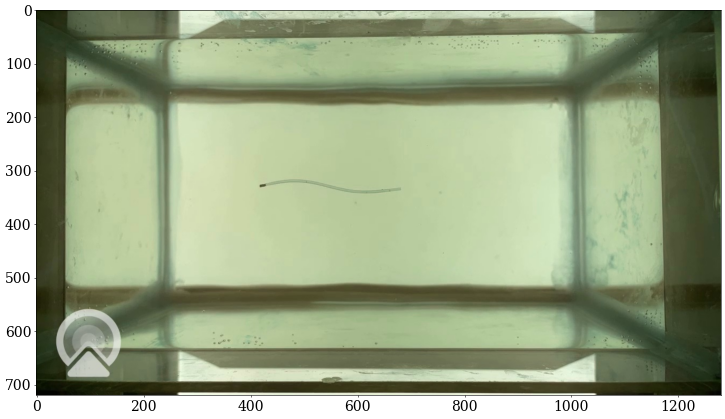

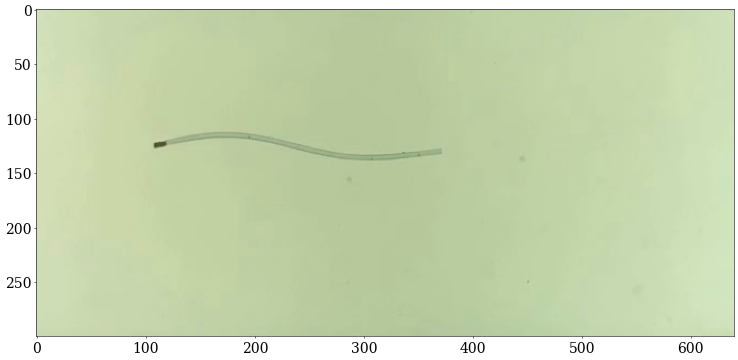

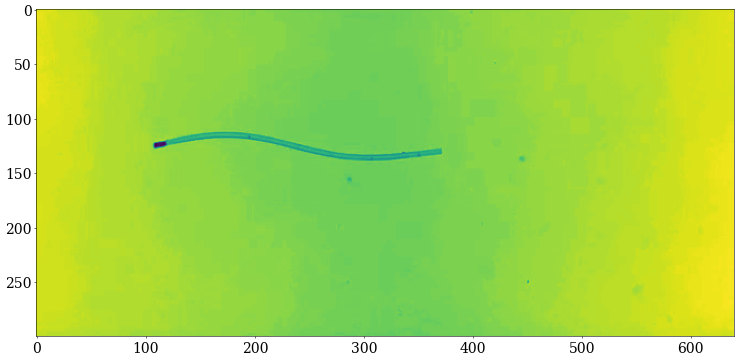

In [41]:
im = cv.imread('fotos\\Capturas\\Camo Snapshot 2024-05-17 12-04-24 - 10Hz.jpg')
plt.figure()
plt.imshow(im)
im = cv.flip(im, 1)
plt.figure()
plt.imshow(im)

im_cut = cortar(im, limites=lim)
plt.figure()
plt.imshow(im_cut)

im_gray = gris(im_cut)
plt.figure()
plt.imshow(im_gray)

Como la cola es más clara que la cabeza hay que cambiar el threshold al binarizar, pero así como está no hay suficiente resolución en la escala de valores. Para solucionar eso enmascaramos la cabeza del nadador de la imagen y renormalizamos la imagen por su máximo y mínimo valor (función guillotina).  

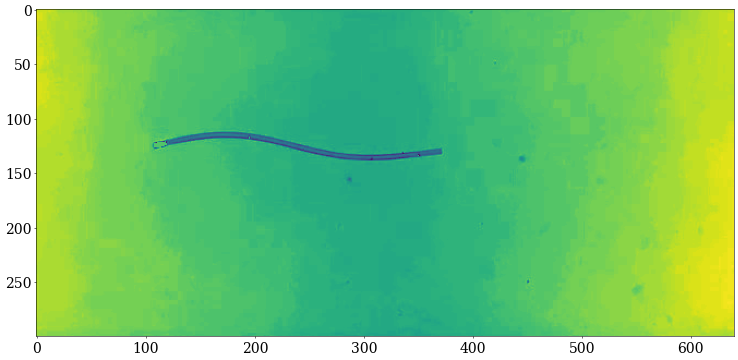

In [42]:
im_decap = guillotina(im_gray)
plt.figure()
plt.imshow(im_decap)

En muchos de los frames al binarizar la cola queda con "huecos" y se ve el contorno de la cabeza. Además aparecen agujeros en el fondo. Se corrige binarizando con la función _binarize_TAIL_.

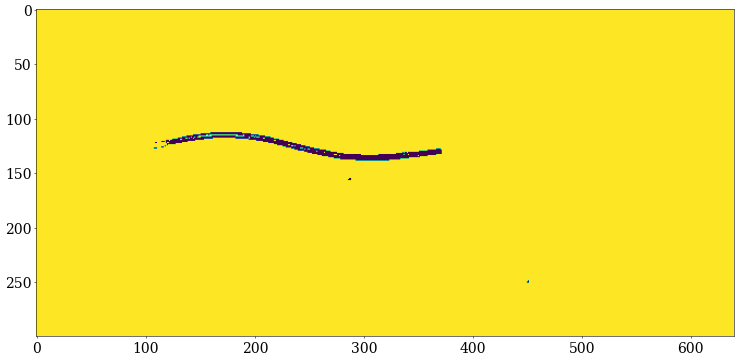

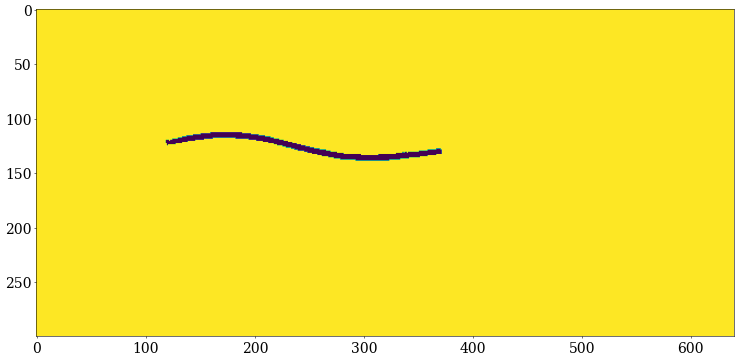

In [45]:
im_binary = binarize(im_decap, th=THRESHOLD-15)
plt.figure()
plt.imshow(im_binary)

im_binary = binarize_TAIL(im_decap)
plt.figure()
plt.imshow(im_binary)

Como el filamento tiene bastantes píxeles de diámetro al aplicar directamente _skeletonize_ aparecen ramas que conectan con el contorno, o incluso "globos" si al binarizar quedó alguna mancha clara sin rellenar en el interior del filamento y saltos poco suaves, que no reflejan la forma general de la cola. Se corrige en la función _skeleton_.

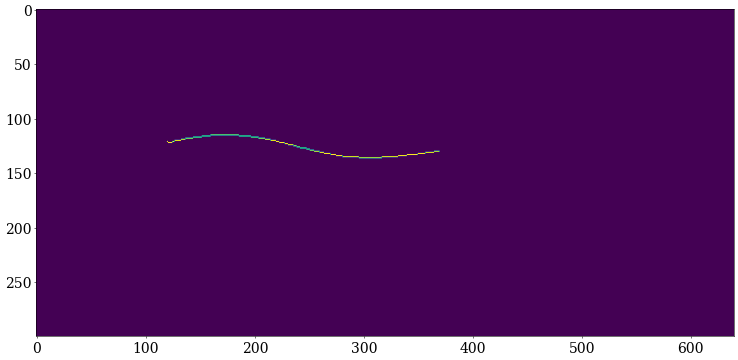

In [52]:
im_sk, _ = skeleton(im_binary)
plt.figure()
plt.imshow(im_sk)

### Ejemplo con video (ECO20 45mm 1,00Vpp 7,66Hz)

Antes de que se abra y después de que se cierre la ventana del video analizado hay un tiempo de espera por los frames donde la cola no está entera (o directamente no está) que no se analizan. Hay que dejar que termine de correr para que se guarden los datos. Por eso registramos cuáles son los frames efectivamente analizados; es necesario para relacionar correctamente la forma de la cola con los datos de posición de la cabeza.

In [66]:
video = cv.VideoCapture('videos\\ECO20-45mm-PECERA1\\ECO20-45mm-1,00Vpp-7,66Hz.mp4')
frame_count, lista_count, tiempo, sk, tail = track_TAIL(video, lim, SHOW=True)

# revisar el tema del guardado con Nico

termina en: 1154


In [61]:
import os

for filename in os.listdir('videos\\ECO20-45mm-PECERA1'):
    print(f'Analizando {filename}')
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos\\ECO20-45mm-PECERA1\\'+filename)
    lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    fc, lc, t, sk, tail = track_TAIL(video, lim, SHOW=True)
    print(fc, len(lc), len(t), len(sk))

Analizando ECO20-45mm-1,00V-3Hz.mp4
termina en: 2817
1634 1634 1634 1634
Analizando ECO20-45mm-1,00Vpp-10,01Hz.mp4
termina en: 689
340 340 340 340
Analizando ECO20-45mm-1,00Vpp-2Hz.mp4
termina en: 5028
3166 3166 3166 3166
Analizando ECO20-45mm-1,00Vpp-7,33Hz.mp4
termina en: 901
562 562 562 562
Analizando ECO20-45mm-1,00Vpp-7,66Hz.mp4
termina en: 879
417 417 417 417
Analizando ECO20-45mm-1,00Vpp-7Hz.mp4
termina en: 2074
1192 1192 1192 1192
Analizando ECO20-45mm-1,00Vpp-9,01Hz.mp4
termina en: 794
366 366 366 366
Analizando ECO20-45mm-1,01V-4Hz.mp4
termina en: 3133
1815 1815 1815 1815
Analizando ECO20-45mm-1,01Vpp-6Hz.mp4
termina en: 2513
1474 1474 1474 1474
Analizando ECO20-45mm-1,01Vpp-8Hz.mp4
termina en: 886
455 455 455 455
Analizando ECO20-45mm-1,02mVpp-5Hz.mp4
termina en: 2596
1564 1564 1564 1564
Analizando ECO20-45mm-1,49Vpp-8Hz.mp4
termina en: 571
263 263 263 263
Analizando ECO20-45mm-1,50Vpp-10,01Hz.mp4
termina en: 438
197 197 197 197
Analizando ECO20-45mm-1,50Vpp-2Hz.mp4
termina 